In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Rescaling,RandomRotation,Resizing,RandomFlip
import matplotlib.pyplot as plt

2025-06-22 15:13:58.307869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750585438.320620    5692 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750585438.324595    5692 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750585438.335897    5692 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750585438.335909    5692 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750585438.335911    5692 computation_placer.cc:177] computation placer alr

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Data',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


I0000 00:00:1750585445.360959    5692 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2608 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

2025-06-22 15:14:09.701070: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


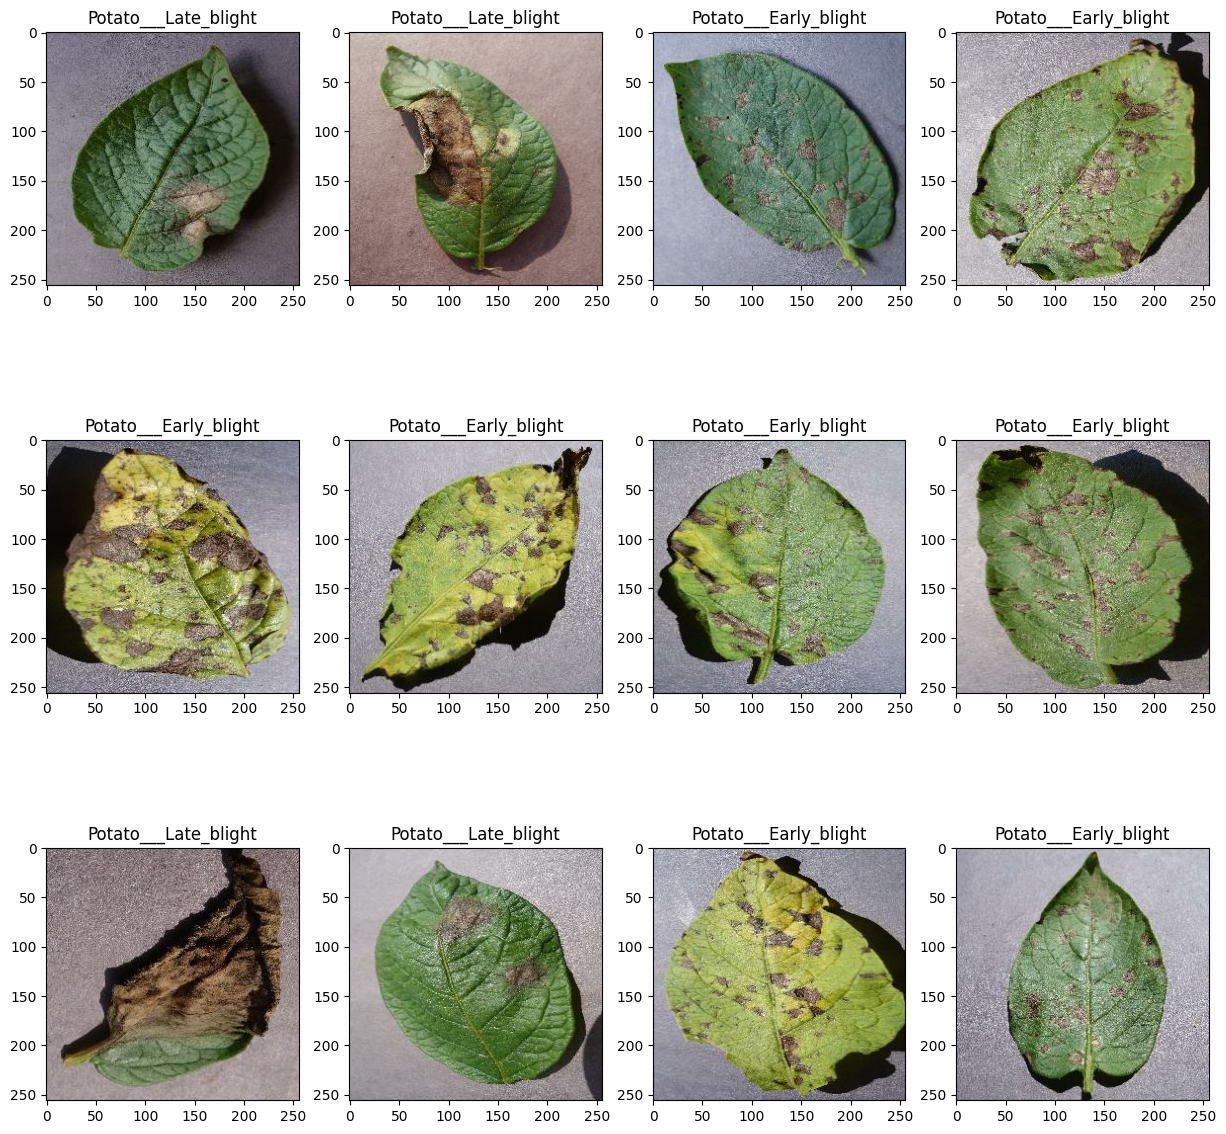

In [6]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('int'))
        plt.title(class_names[int(label_batch[i])])

In [7]:
def get_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, test_ds, val_ds

        

In [8]:
train_ds,test_ds,val_ds = get_partitions_tf(dataset)

In [9]:
len(train_ds)

54

In [10]:
len(test_ds)

8

In [11]:
len(val_ds)

6

In [12]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescaling = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [14]:
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescaling,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

/home/abhishek/GPU_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/50


2025-06-22 15:14:33.623841: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
I0000 00:00:1750585474.202943    5825 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-22 15:14:39.057981: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.4564 - loss: 0.9370

2025-06-22 15:15:03.895755: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 462ms/step - accuracy: 0.4568 - loss: 0.9365 - val_accuracy: 0.6302 - val_loss: 0.8659
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.5205 - loss: 0.8715 - val_accuracy: 0.5052 - val_loss: 0.8176
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.6572 - loss: 0.7031 - val_accuracy: 0.6927 - val_loss: 0.7927
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.7585 - loss: 0.5742 - val_accuracy: 0.8542 - val_loss: 0.3905
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.8649 - loss: 0.3302 - val_accuracy: 0.8906 - val_loss: 0.3054
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.8385 - loss: 0.3716 - val_accuracy: 0.8333 - val_loss: 0.3514
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.8547 - loss: 0.3281 - val_accuracy: 0.8958 - val_loss: 0.2191
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.9120 - loss: 0.2378 - val_accuracy: 0.895

In [21]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9663 - loss: 0.0634


In [22]:
scores

[0.06936700642108917, 0.96875]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
history.history['accuracy'][49]

0.9941314458847046

In [33]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

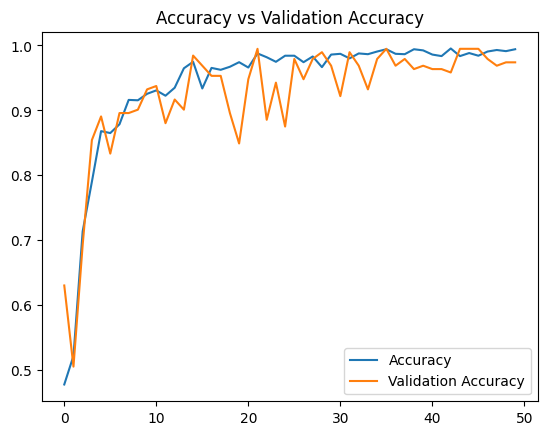

In [43]:
plt.plot(range(50),acc,label='Accuracy')
plt.plot(range(50),val_acc,label='Validation Accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.legend(loc='lower right')

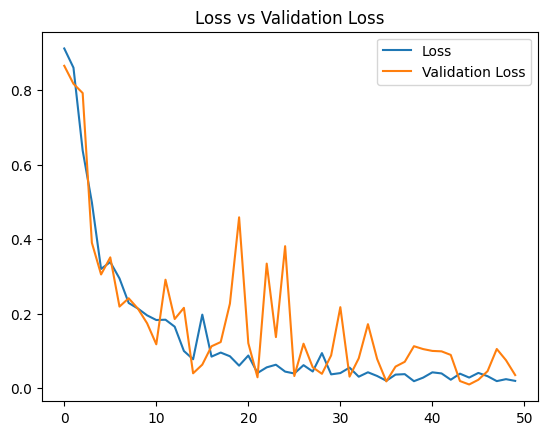

In [45]:
plt.plot(range(50),loss,label='Loss')
plt.plot(range(50),val_loss,label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.legend(loc='upper right')

# Saving the Model

In [46]:
model.save('Potato_Model_01.h5')